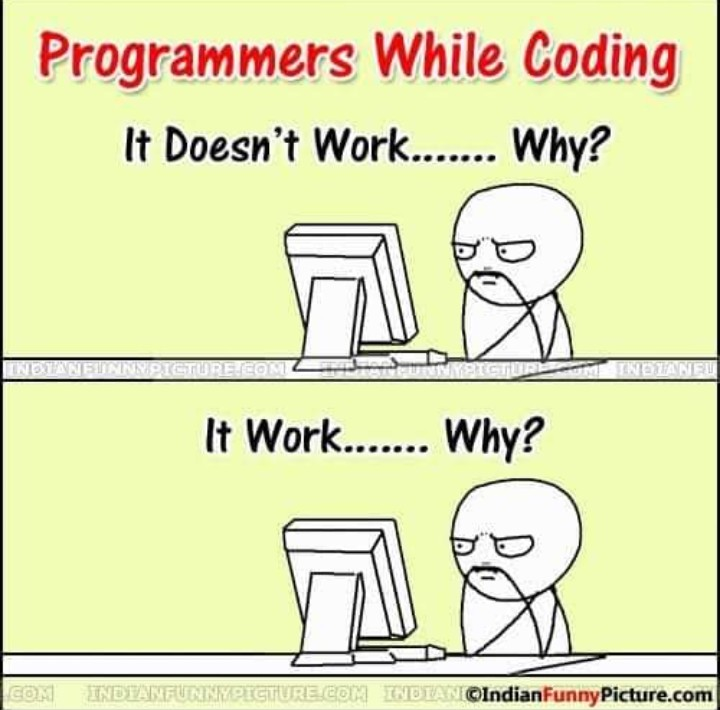

In [204]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

from PIL import Image



print("Libraries imported successfully")


Libraries imported successfully


In [205]:
# set the hyperparameters
lr = 0.0001
batch_size = 32
epochs = 10

In [206]:
# set seed and random value
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [207]:
# get the directory
base_dir = "C:/Users/infaw/Downloads/Tumor/"

train_dir = "train"
test_dir = "test"

In [208]:
# get the train and test list
train_list = glob.glob(os.path.join(base_dir,train_dir, '*.jpg'))

test_list = glob.glob(os.path.join(base_dir, test_dir, '*.jpg'))

In [209]:
# check the list of dataset in the train
len(train_list), len(test_list)

(188, 20)

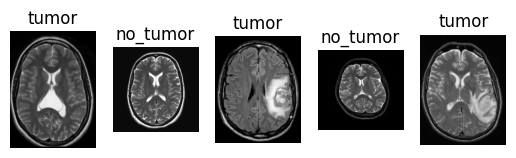

In [210]:
# check the datasbase
random_idx = np.random.randint(1, 188, size=5)

fig = plt.figure()
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2, 5, i)
    img = Image.open(train_list[idx])
    ax.imshow(img)
    ax.set_title(train_list[idx].split('/')[-1].split(".")[0].split("\\")[-1])
    ax.axis('off')
    i += 1
    
plt.show()


In [211]:
train_list[0].split('/')[-1].split(".")[0].split("\\")[-1]

'no_tumor'

In [212]:
print(len(train_list), len(test_list))

188 20


In [213]:
# augment the data
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [214]:
# load the data
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    # load one of the images
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split(".")[0].split("\\")[-1]
        if label == "tumor":
            label = 0
        elif label == 'no_tumor':
            label = 1
            
        return img_transformed, label


In [215]:
# get the dataset loaded
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)

In [216]:
# use the Dataloader to load the all the images
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)


In [217]:
# get the len
print(len(train_data), len(test_data))

188 20


In [218]:
# check the image shape
train_data[0][0].shape

torch.Size([3, 128, 128])

In [219]:
# build the model
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(64*1*1,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [220]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (rel

In [221]:
# set loss function and optimizer
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [222]:
#Train the network
epochs = 10
count = 0
loss_list = []
accuracy_list = []
iteration_list = []


for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        train = data.to(device)
        label = label.to(device)
        
        output = model(train)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    count += 1   
    accuracy_list.append(epoch_accuracy)
    loss_list.append(epoch_loss)
    iteration_list.append(count)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    

Epoch : 1, train accuracy : 0.6212797164916992, train loss : 0.6534818410873413
Epoch : 2, train accuracy : 0.6748511791229248, train loss : 0.6133153438568115
Epoch : 3, train accuracy : 0.664434552192688, train loss : 0.6136518120765686
Epoch : 4, train accuracy : 0.676339328289032, train loss : 0.5926232933998108
Epoch : 5, train accuracy : 0.6964285373687744, train loss : 0.5566414594650269
Epoch : 6, train accuracy : 0.6473214030265808, train loss : 0.6370134353637695
Epoch : 7, train accuracy : 0.7276785373687744, train loss : 0.5554937124252319
Epoch : 8, train accuracy : 0.7046130895614624, train loss : 0.573143720626831
Epoch : 9, train accuracy : 0.7328869104385376, train loss : 0.5459073185920715
Epoch : 10, train accuracy : 0.691220223903656, train loss : 0.5919633507728577


In [223]:
len(iteration_list)
new_loss_list = []
new_accuracy_list = []


for i in range(len(iteration_list)):
    new_loss_list.append(loss_list[i].detach().numpy())
    new_accuracy_list.append(accuracy_list[i].detach().numpy())

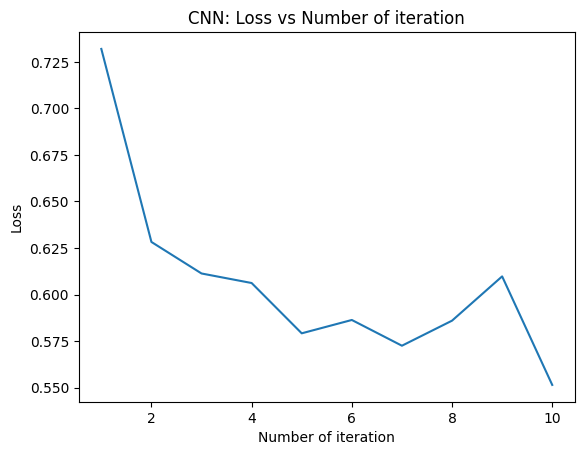

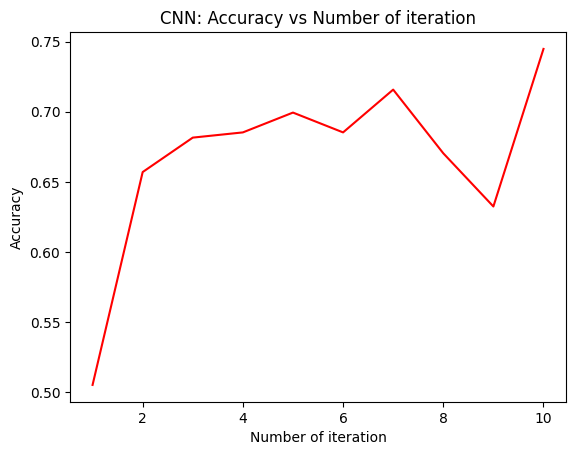

In [195]:
# visualization loss 
plt.plot(iteration_list,new_loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list, new_accuracy_list, color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [196]:
tumor_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tumor_probs += list(zip(list(fileid), preds_list))

In [197]:
tumor_probs.sort(key = lambda x : int(x[0]))
tumor_probs

[('21', 0.3091825842857361),
 ('22', 0.27577313780784607),
 ('23', 0.3048097491264343),
 ('24', 0.44326749444007874),
 ('25', 0.4691348671913147),
 ('26', 0.48114556074142456),
 ('27', 0.10787191241979599),
 ('28', 0.3006744682788849),
 ('29', 0.33440905809402466),
 ('30', 0.35455766320228577),
 ('33', 0.40842440724372864),
 ('34', 0.367764413356781),
 ('35', 0.6081117987632751),
 ('36', 0.6764432787895203),
 ('37', 0.43291550874710083),
 ('38', 0.500555694103241),
 ('39', 0.5777077674865723),
 ('40', 0.8227984309196472),
 ('55', 0.646964430809021),
 ('58', 0.4017198085784912)]

In [198]:
idx = list(map(lambda x: x[0],tumor_probs))
prob = list(map(lambda x: x[1],tumor_probs))

In [199]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission

,id,label
0,21,0.309183
1,22,0.275773
2,23,0.304810
3,24,0.443267
4,25,0.469135
5,26,0.481146
6,27,0.107872
7,28,0.300674
8,29,0.334409
9,30,0.354558


In [200]:
# save the result as a csv file
submission.to_csv('result.csv',index=False)

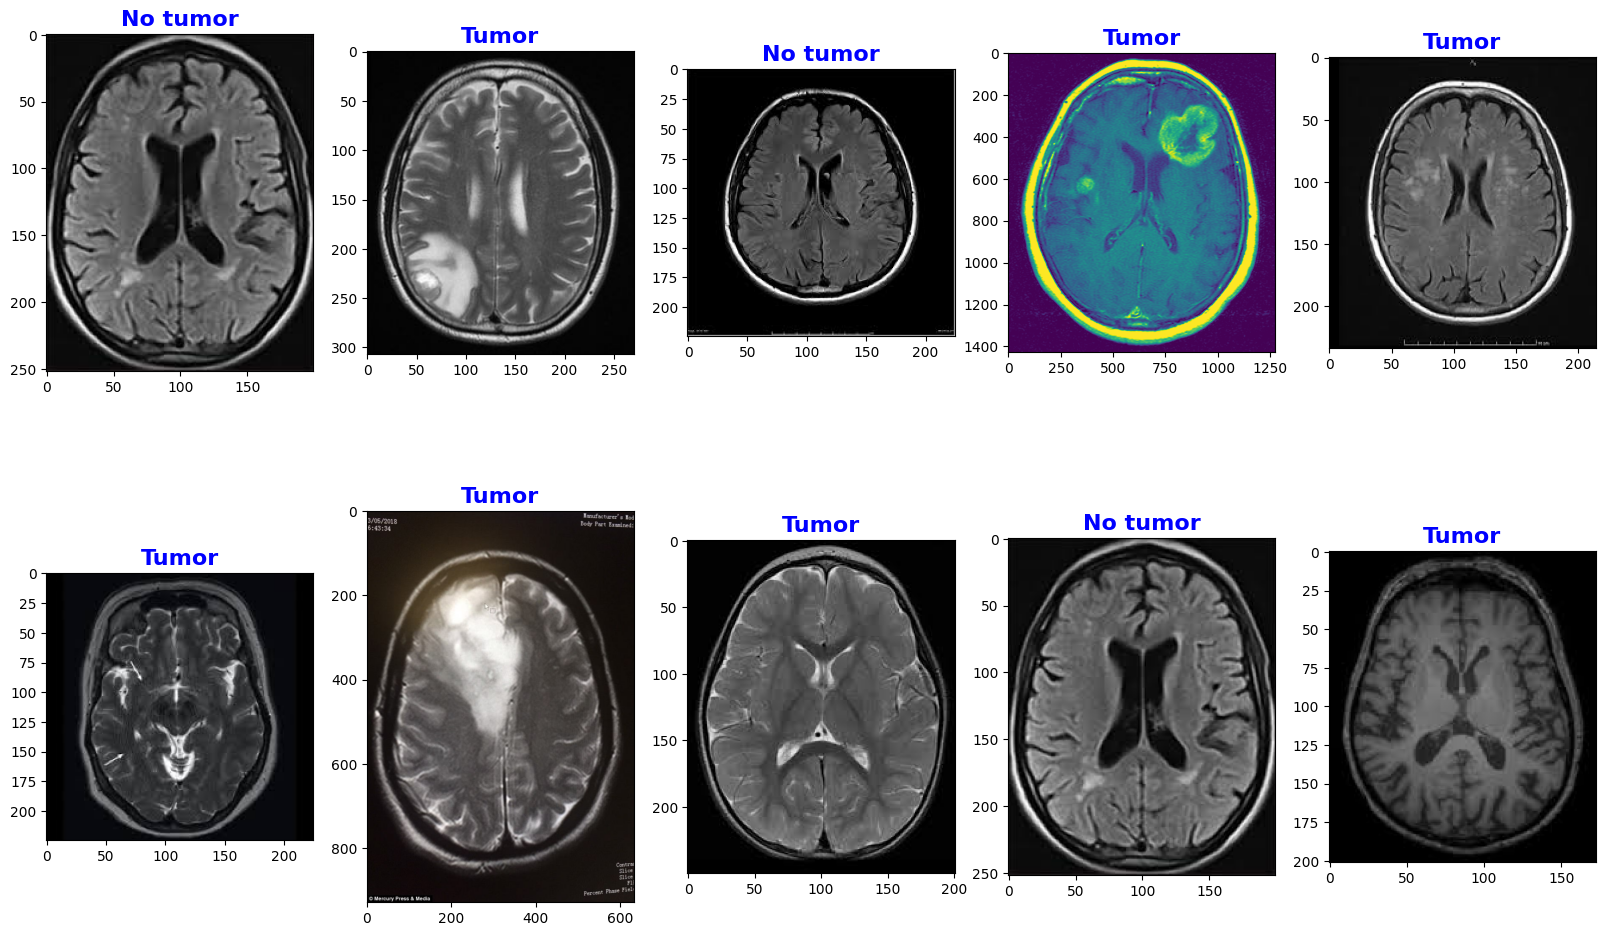

In [203]:
import random

id_list = []
class_ = {0: 'Tumor', 1: 'No tumor'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(base_dir, test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label], color = 'blue', weight='bold', fontsize=16)
    ax.imshow(img)


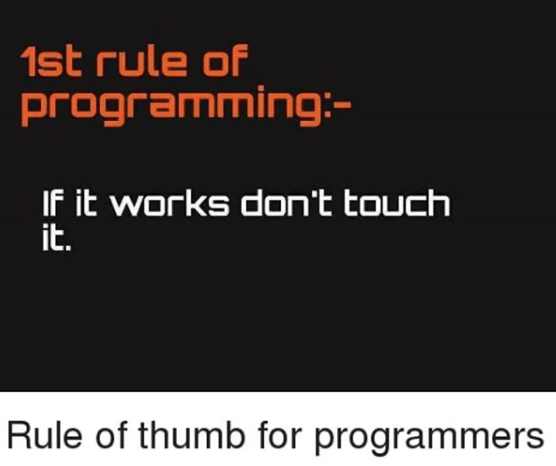